In [1]:
# important lib
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
sys.path.append("..")

# torch + gpu
import gc
import torch

# SAM
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor

# Helper function

In [2]:
np.random.seed(200)
_palette = ((np.random.random((3*255))*0.7+0.3)*255).astype(np.uint8).tolist()
_palette = [0,0,0]+_palette

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def save_prediction(pred_mask,output_dir,file_name):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask.save(os.path.join(output_dir,file_name))

# Các đường dẫn cần thiết

In [3]:
folder_name = 'bus'
io_args = {
    'input_img': f'/home/son/Desktop/vot/vot2023/data/vot2023/{folder_name}/color/',
    'input_video': f'/home/son/Desktop/vot/vot2023/data/vot2023/{folder_name}/{folder_name}.mp4',
    'bbox': f'/home/son/Desktop/vot/vot2023/output/test/tracking_results/procontext/{folder_name}',
    'output_mask_dir': f'./VOTS_2023_result/{folder_name}/mask/', # save pred masks
    'output_video': f'./VOTS_2023_result/{folder_name}/{folder_name}.mp4', # mask+frame vizualization, mp4 or avi, else the same as input video
}

In [4]:
img_path = [os.path.join(io_args['input_img'], img_name) for img_name in sorted(os.listdir(io_args['input_img']))]
img_path

['/home/son/Desktop/vot/vot2023/data/vot2023/bus/color/00000001.jpg',
 '/home/son/Desktop/vot/vot2023/data/vot2023/bus/color/00000002.jpg',
 '/home/son/Desktop/vot/vot2023/data/vot2023/bus/color/00000003.jpg',
 '/home/son/Desktop/vot/vot2023/data/vot2023/bus/color/00000004.jpg',
 '/home/son/Desktop/vot/vot2023/data/vot2023/bus/color/00000005.jpg',
 '/home/son/Desktop/vot/vot2023/data/vot2023/bus/color/00000006.jpg',
 '/home/son/Desktop/vot/vot2023/data/vot2023/bus/color/00000007.jpg',
 '/home/son/Desktop/vot/vot2023/data/vot2023/bus/color/00000008.jpg',
 '/home/son/Desktop/vot/vot2023/data/vot2023/bus/color/00000009.jpg',
 '/home/son/Desktop/vot/vot2023/data/vot2023/bus/color/00000010.jpg',
 '/home/son/Desktop/vot/vot2023/data/vot2023/bus/color/00000011.jpg',
 '/home/son/Desktop/vot/vot2023/data/vot2023/bus/color/00000012.jpg',
 '/home/son/Desktop/vot/vot2023/data/vot2023/bus/color/00000013.jpg',
 '/home/son/Desktop/vot/vot2023/data/vot2023/bus/color/00000014.jpg',
 '/home/son/Desktop/

# SAM

In [5]:
sam_checkpoint = "/home/son/Desktop/vot/vot2023/segment-anything/pretrained/sam_vit_l_0b3195.pth"
model_type = "vit_l"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# Predictor
predictor = SamPredictor(sam)

Lấy tất cả 4 điểm tọa độ `xywh` và chuyển hết thành `tlbr` của các objects cần track

In [6]:
obj_id = next(os.walk(io_args['bbox']))[1]
num_of_obj = len(set(obj_id))
bbox_file_paths = [os.path.join(io_args['bbox'], id, folder_name + '.txt') for id in obj_id]

bbox_files = [open(bbox_path, 'r') for bbox_path in bbox_file_paths]

all_tlbr = [] # Lấy tất cả tlbr của tất cả các obj
for bbox_file in bbox_files:
    tlbr_obj = []
    for line in bbox_file:
        xywh = [int(coor) for coor in line.split()]
        tlbr = np.copy(xywh)
        tlbr[2:] += np.array(xywh[:2])
        tlbr_obj.append(tlbr)
    all_tlbr.append(tlbr_obj)

# SAM from bbox of ProContEXT

### From video

In [12]:
cap = cv2.VideoCapture(io_args['input_video'])
frame_idx = 0

color = [np.concatenate([np.random.random(3), np.array([0.6])], axis=0) for i in range(num_of_obj)]

while cap.isOpened():
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
 
    # Set frame for Predictor of SAM
    predictor.set_image(frame)
    
    # Get coordinate of bbox from ProContEXT
    input_boxes = []
    for obj in range(num_of_obj):
        input_boxes.append(all_tlbr[obj][frame_idx])
    
    input_boxes_tensor = torch.tensor(input_boxes, device=predictor.device)
    
    transform_boxes = predictor.transform.apply_boxes_torch(input_boxes_tensor, frame.shape[:2])
    
    # Predict mask with SAM
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transform_boxes,
        multimask_output=False,
    )
    
    out_mask = np.zeros(masks.shape[-2:]) # masks.shape = [2, 1, 720, 1280]

    for obj_id, mask in enumerate(masks):
        print(np.unique(mask != 0))
        out_mask += (mask[0] * (obj_id + 1)).numpy()
    
    # Save output mask
    path = os.path.join(io_args['output_mask_dir'])
    
    if not os.path.exists(path):
        print(f"[INFO] Making {path} ...")
        os.makedirs(path)
        print(f"[INFO] Done!")
    
    save_prediction(out_mask, path, "%08d.png" % (frame_idx + 1))
    
    gc.collect()
    torch.cuda.empty_cache()
    frame_idx += 1


[False  True]
[False  True]


KeyboardInterrupt: 

### From folder of image

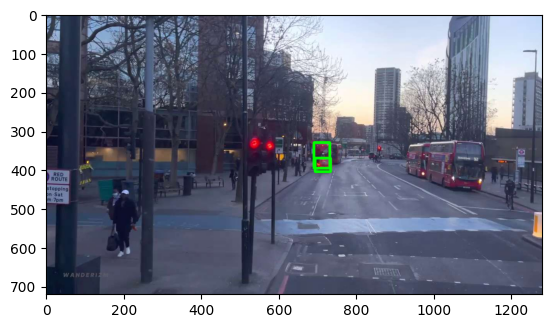

In [56]:
frame_idx = 422

for i in range(frame_idx, len(img_path)):
    frame = cv2.imread(img_path[i])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Set frame for Predictor of SAM
    predictor.set_image(frame)
    
    # Get coordinate of bbox from ProContEXT
    input_boxes = []
    for obj in range(num_of_obj):
        input_boxes.append(all_tlbr[obj][i])
    
    for box in input_boxes:
        cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]),
                         (0, 255, 0), 5)
    plt.imshow(frame)
    
    input_boxes_tensor = torch.tensor(input_boxes, device=predictor.device)
    
    transform_boxes = predictor.transform.apply_boxes_torch(input_boxes_tensor, frame.shape[:2])
    
    # Predict mask with SAM
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transform_boxes,
        multimask_output=False,
    )
    
    out_mask = np.zeros(masks.shape[-2:]) # masks.shape = [2, 1, 720, 1280]
    
    for obj_id, mask in enumerate(masks):
        mask = (mask[0] * (obj_id + 1)).numpy()
        out_mask = np.where(mask, mask, out_mask)
#         out_mask += (mask[0] * (obj_id + 1)).numpy()
    
    break
#     # Save output mask
#     path = os.path.join(io_args['output_mask_dir'])
    
#     if not os.path.exists(path):
#         print(f"[INFO] Making {path} ...")
#         os.makedirs(path)
#         print(f"[INFO] Done!")
    
#     save_prediction(out_mask, path, "%08d.png" % (i + 1))
    
#     gc.collect()
#     torch.cuda.empty_cache()

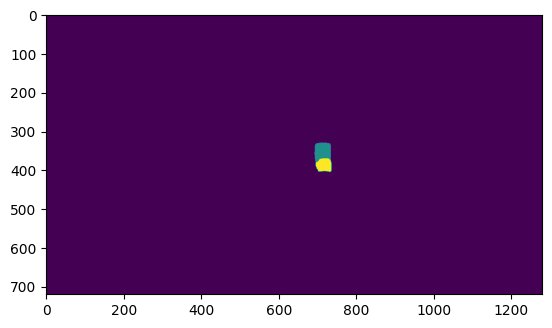

In [57]:
plt.imshow(out_mask)

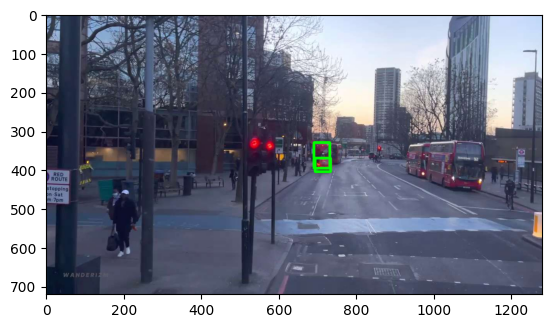

In [29]:
plt.imshow(frame)

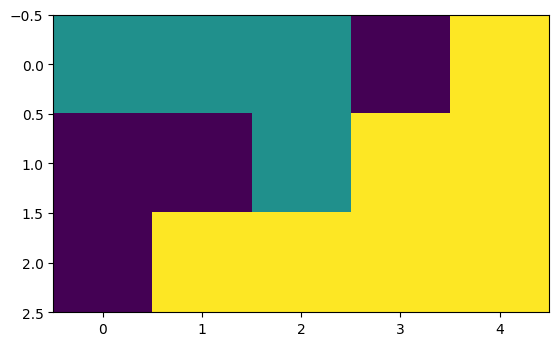

In [55]:
mask1 = np.array([[1, 1, 1, 0, 0],
                  [0, 0, 1, 0, 0],
                  [0, 1, 1, 1, 0]])

mask2 = np.array([[0, 0, 0, 0, 2],
                  [0, 0, 0, 2, 2],
                  [0, 2, 2, 2, 2]])

img = np.zeros_like(mask1)

img = np.where(mask1, mask1, img)
img = np.where(mask2, mask2, img)
plt.imshow(img)

In [47]:
np.intersect1d(mask1, mask2)

array([0])

# Save results for visualization

In [4]:
from scipy.ndimage import binary_dilation

def save_prediction(pred_mask,output_dir,file_name):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask.save(os.path.join(output_dir,file_name))
    
def colorize_mask(pred_mask):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask = save_mask.convert(mode='RGB')
    return np.array(save_mask)

def draw_mask(img, mask, alpha=0.5, id_countour=False):
    img_mask = np.zeros_like(img)
    img_mask = img
    if id_countour:
        # very slow ~ 1s per image
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[obj_ids!=0]

        for id in obj_ids:
            # Overlay color on  binary mask
            if id <= 255:
                color = _palette[id*3:id*3+3]
            else:
                color = [0,0,0]
            foreground = img * (1-alpha) + np.ones_like(img) * alpha * np.array(color)
            binary_mask = (mask == id)

            # Compose image
            img_mask[binary_mask] = foreground[binary_mask]

            countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
            img_mask[countours, :] = 0
    else:
        binary_mask = (mask!=0)
        countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
        foreground = img*(1-alpha)+colorize_mask(mask)*alpha
        img_mask[binary_mask] = foreground[binary_mask]
        img_mask[countours,:] = 0
        
    return img_mask.astype(img.dtype)

In [29]:
mask_path = [os.path.join(io_args['output_mask_dir'], mask_name) for mask_name in sorted(os.listdir(io_args['output_mask_dir']))]
img_path = [os.path.join(io_args['input'], img_name) for img_name in sorted(os.listdir(io_args['input']))]
len(mask_path), len(img_path)

(4071, 8087)

In [37]:
# draw pred mask on frame and save as a video
cap = cv2.VideoCapture(io_args['input_video'])
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
num_frames = len(mask_path)

if io_args['input_video'][-3:]=='mp4':
    fourcc =  cv2.VideoWriter_fourcc(*"mp4v")
elif io_args['input_video'][-3:] == 'avi':
    fourcc =  cv2.VideoWriter_fourcc(*"MJPG")
    # fourcc = cv2.VideoWriter_fourcc(*"XVID")
else:
    fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
out = cv2.VideoWriter(io_args['output_video'], fourcc, fps, (width, height))

frame_idx = 0
for frame_idx in range(num_frames):
    img = cv2.imread(img_path[frame_idx])
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path[frame_idx])
#     mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    out_frame = img | mask
    out.write(out_frame)
    print('frame {} writed'.format(frame_idx),end='\r')

out.release()
print("\n{} saved".format(io_args['output_video']))
print('\nfinished')

torch.cuda.empty_cache()
gc.collect()

frame 4070 writed
./VOTS_2023_result/bus/bus.mp4 saved

finished


0

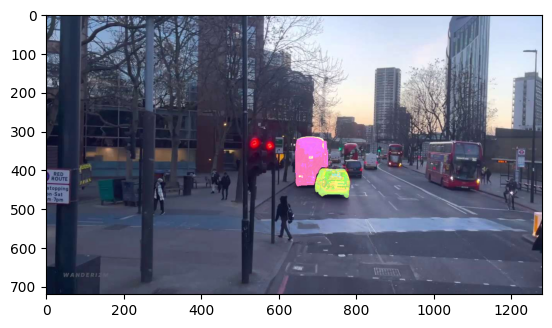

In [45]:
out_img = img | img_mask
plt.imshow(out_img)